In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

from keras import layers, losses, utils, optimizers
from keras.datasets import cifar10

c:\Users\olive\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the CIFAR10 dataset

In [2]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

#### Show some samples

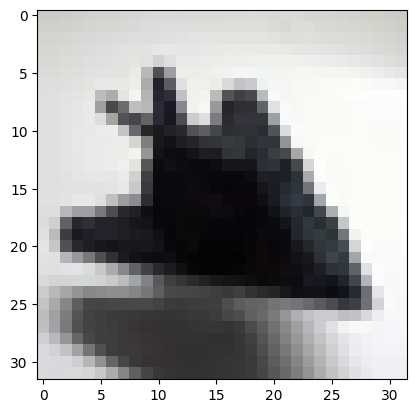

In [21]:
plt.imshow(train_images[np.random.randint(0, 50)])

### Generator

In [22]:
def Generator():
    generator = keras.Sequential()

    # input dense layer
    generator.add(layers.Dense(8 * 8 * 128, use_bias=False, input_shape=(100,)))
    generator.add(layers.LeakyReLU(alpha=0.2))
    generator.add(layers.Reshape((8, 8, 128)))

    # upsampling 1
    generator.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
    generator.add(layers.LeakyReLU(alpha=0.2))

    # upsampling 2
    generator.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"))
    generator.add(layers.LeakyReLU(alpha=0.2))

    # generator image output
    generator.add(layers.Conv2D(3, (8, 8), padding="same", activation="tanh"))

    return generator



#### Generator random output with no training

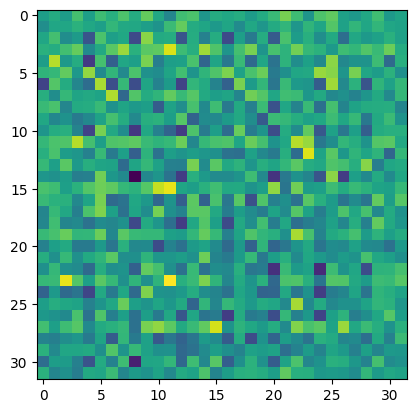

In [23]:
generator = Generator()

noise = tf.random.normal([1, 100])
generated_random_image = generator(noise, training=False)

plt.imshow(generated_random_image[0, :, :, 0])

### Discriminator

In [24]:
def Discriminator():
    discriminator = keras.Sequential()

    discriminator.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same", input_shape=[32, 32, 3]))
    discriminator.add(layers.LeakyReLU(alpha=0.2))
    discriminator.add(layers.Dropout(0.3))

    discriminator.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"))
    discriminator.add(layers.LeakyReLU(alpha=0.2))
    discriminator.add(layers.Dropout(0.3))

    discriminator.add(layers.Flatten())
    discriminator.add(layers.Dense(1, activation="sigmoid"))

    discriminator.compile(optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss="binary_crossentropy")

    return discriminator



### Connect Generator and Discriminator to GAN

In [25]:
def CifarGAN(generator, discriminator):
    discriminator.trainable = False

    gan = keras.Sequential()
    gan.add(generator)
    gan.add(discriminator)

    gan.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5))

    return gan



### Load and preprocess training Data

In [26]:
def LoadandPreprocess(train_images):
    train_images = train_images.astype("float32")
    return (train_images - 127.5) / 127.5



### Training

#### Hyperparams

In [27]:
TRAIN_EPOCHS = 2
BATCH_SIZE = 128

#### Generating real and fake samples 

In [28]:
def GenerateLatentPoints(latent_dim, n_samples):
    input_data = np.random.randn(latent_dim * n_samples)
    input_data = input_data.reshape(n_samples, latent_dim)
    return input_data

def GenerateRealSamples(dataset, n_samples):
    index = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[index]
    y = np.ones((n_samples, 1))
    return X, y

def GenerateFakeSamples(generator, latent_dim, n_samples):
    input_data = GenerateLatentPoints(latent_dim, n_samples)
    X = generator.predict(input_data)
    y = np.zeros((n_samples, 1))
    return X, y



#### Train steps

In [36]:
def Train(generator, discriminator, gan, dataset, latent_dim, train_epochs=TRAIN_EPOCHS):
    # define batching sizes
    batch_per_epoch = int(dataset.shape[0] / BATCH_SIZE)
    half_batch = int(BATCH_SIZE / 2)

    for i in range(train_epochs):
        for j in range(batch_per_epoch):
            # get loss from real images
            print(GenerateRealSamples(dataset, half_batch))
            X_real, y_real = GenerateRealSamples(dataset, half_batch)
            disc_loss_real = discriminator.train_on_batch(X_real, y_real)

            # get loss from generated fake images
            X_fake, y_fake = GenerateFakeSamples(generator, latent_dim, n_samples=half_batch)
            disc_loss_fake = discriminator.train_on_batch(X_fake, y_fake)

            # construct full loss
            X_gan = GenerateLatentPoints(latent_dim=latent_dim, n_samples=BATCH_SIZE)
            y_gan = np.ones((BATCH_SIZE, 1))
            gan_loss = gan.train_on_batch(X_gan, y_gan)
            
    # Save GAN model
    gan.save("cifar_gan_v1.h5")



#### Training the GAN

In [ ]:
LATENT_DIM = 100

# load & process training dataset
dataset = LoadandPreprocess(train_images=train_images)

# get disc and generator models
discriminator = Discriminator()
generator = Generator()

# assemble the GAN
cifar_gan = CifarGAN(generator=generator, discriminator=discriminator)

# train steps for GAN, Generator & Discriminator
Train(
    generator=generator, 
    discriminator=discriminator, 
    gan=cifar_gan, dataset=dataset, 
    latent_dim=LATENT_DIM, 
    train_epochs=TRAIN_EPOCHS
)